# Building an always-up-to-date searchable index of video text transcripts

In this demo, we will build a video to searchable transcript pipeline using pixeltable primitives and openAI whisper. 
Along the way, we demonstrate how we can use pixeltable to:
1) Ingest video files
2) Extract a corresponding audio
3) Transcribe audio to text through a call to openAI whisper
4) Build a semantic index on the text at a sentence granularity, based on sentence_transformers models.
5) Search this index.

Along the way, we highlight the following pixeltable features:

1) We expresss the pipeline as simple operations on tables. Important intermediates, ie. data flowing between pipeline steps,  are easy to inspect for both existing and any new data.
2) Pixeltable helps us preserve views of the same data at different granularities, depending on what is meaningful for the given operations. We can view transcripts at the video level, useful for calls to openai,  but also split them into smaller sentences for more meaningful search resutls, and this relationship is preserved automatically as new data is added.
3) The searchable database is kept up to date when new videos are added, making new videos searchable within an instant, at no extra development or operational effort.

###  We will first download a few exampole videos from youtube.

In [1]:
%pip install git+https://github.com/ytdl-org/youtube-dl

  Cloning https://github.com/ytdl-org/youtube-dl to /private/var/folders/8v/d886z5j13dsctyjpw29t7y480000gn/T/pip-req-build-ljze0xi6
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl /private/var/folders/8v/d886z5j13dsctyjpw29t7y480000gn/T/pip-req-build-ljze0xi6


  Resolved https://github.com/ytdl-org/youtube-dl to commit a08f2b7e4567cdc50c0614ee0a4ffdff49b8b6e6


  Preparing metadata (setup.py) ... -

 done


Note: you may need to restart the kernel to use updated packages.


In [2]:
%%bash
mkdir -p sample_videos
cd sample_videos
youtube-dl 'https://www.youtube.com/watch?v=YwWtDSponlc&ab_channel=CNBCTelevision'
youtube-dl 'https://www.youtube.com/watch?v=L9Tyb_ycRfU&ab_channel=CNBCTelevision'
youtube-dl 'https://www.youtube.com/watch?v=0wJqgHSfYi0&ab_channel=CNBCTelevision'

/Users/orm/mambaforge/envs/pixeltable_39/bin/python


/Users/orm/mambaforge/envs/pixeltable_39/bin/youtube-dl


/Users/orm/mambaforge/envs/pixeltable_39/bin/youtube-dl


[youtube] YwWtDSponlc: Downloading webpage


[download] Right now you want to be invested in companies that don't cater to the consumer, says Jim Cramer-YwWtDSponlc.mp4 has already been downloaded and merged


[youtube] L9Tyb_ycRfU: Downloading webpage


[download] Jim Cramer looks at how the Fed minutes spooked the markets today-L9Tyb_ycRfU.mp4 has already been downloaded and merged


[youtube] 0wJqgHSfYi0: Downloading webpage


[download] Snowflake CEO joins Jim Cramer after earnings report drives stock higher-0wJqgHSfYi0.mp4 has already been downloaded and merged


In [44]:
import pathlib

import pixeltable as pxt
from pixeltable.functions.video import get_metadata, extract_audio
from pixeltable.functions import openai
from embeddings import TextSplitter, e5_embed

In [45]:
pxt.create_dir('transcription_demo', ignore_errors=True)

In [46]:
pxt.drop_table('transcription_demo.sentence_view', ignore_errors=True)
pxt.drop_table('transcription_demo.video_table', ignore_errors=True)
video_table = pxt.create_table('transcription_demo.video_table', {'video': pxt.VideoType()},)

Created table `video_table`.


In [47]:
paths = [str(pathlib.Path(p).absolute()) for p in pathlib.Path('./sample_videos/').iterdir()]
video_table.insert([{'video': video_path} for video_path in paths[:1] ])

Inserting rows into `video_table`: 1 rows [00:00, 612.40 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [49]:
video_table.add_column(audio=extract_audio(video_table.video, format='mp3'))

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/ cells]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio
,

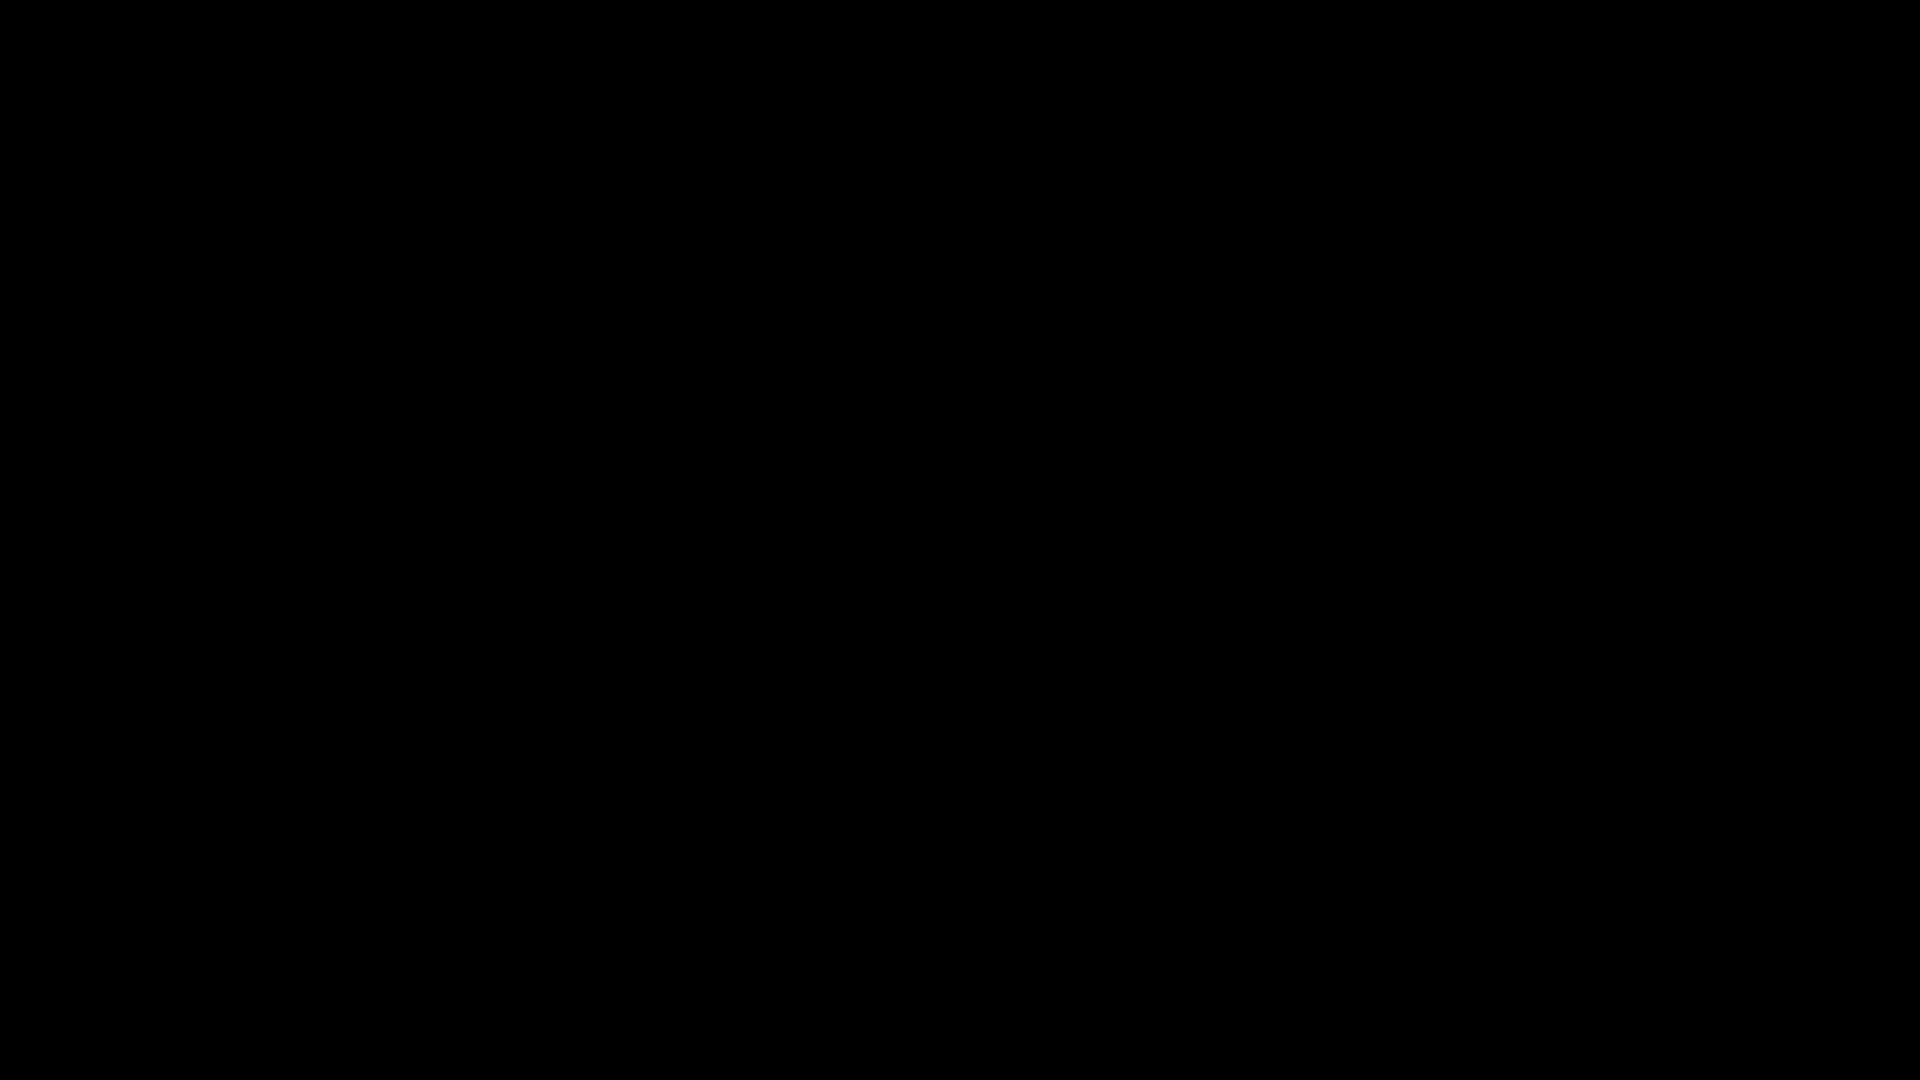

In [50]:
video_table.show()

In [51]:
video_table.add_column(audio_meta=get_metadata(video_table.audio))

Computing cells: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 322.89 cells/s]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio,audio_meta
,,"{'size': 8266796, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 7290936576, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 516.648}], 'bit_rate': 128006, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"

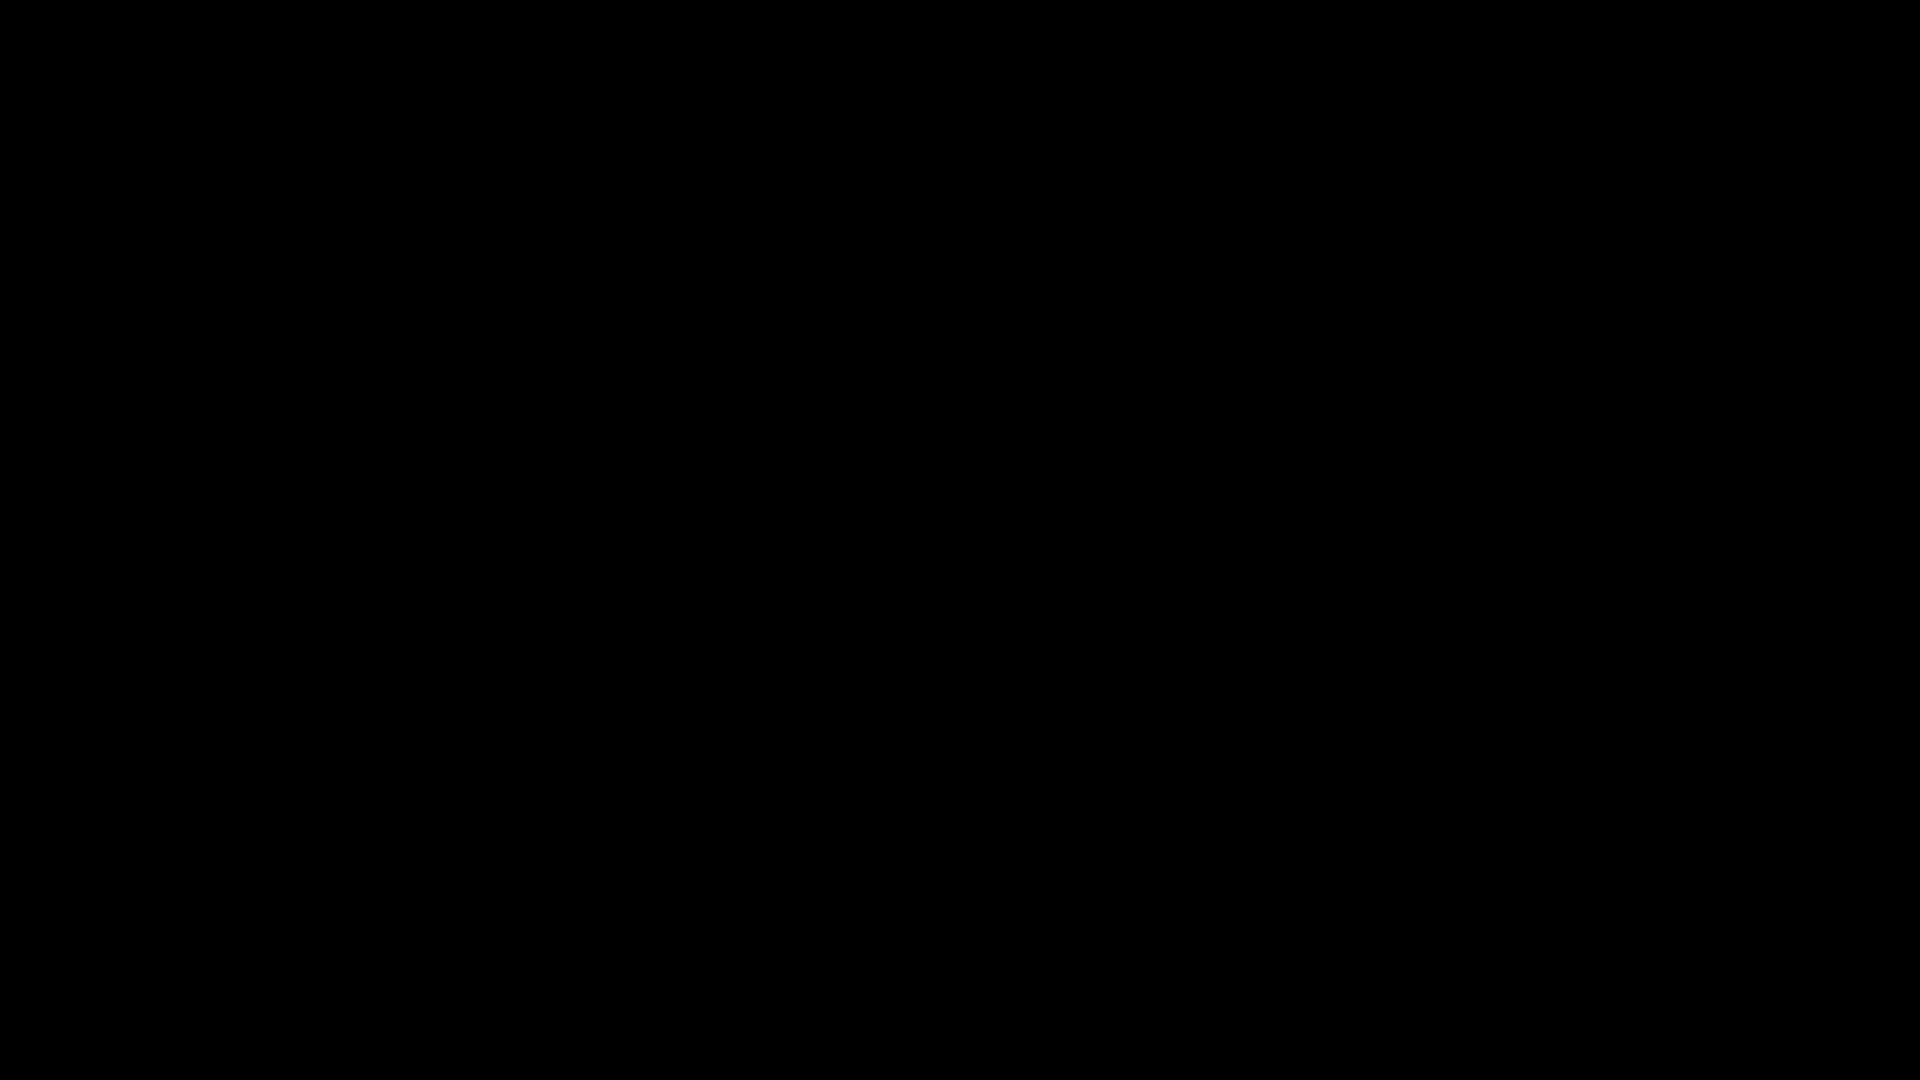

In [52]:
video_table.show()

In [53]:
video_table.add_column(transcription=openai.transcriptions(audio=video_table.audio, model='whisper-1'))

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:26<00:00, 26.29s/ cells]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

video  \
0  /Users/orm/repos/pixeltable/docs/drafts/whispe...   

                                               audio  \
0  /Users/orm/.pixeltable/media/53ff836a5ad5418ea...   

                                          audio_meta  \
0  {'size': 8266796, 'streams': [{'type': 'audio'...   

                                       transcription  
0  {'text': 'The Snowflake back on track after a ...
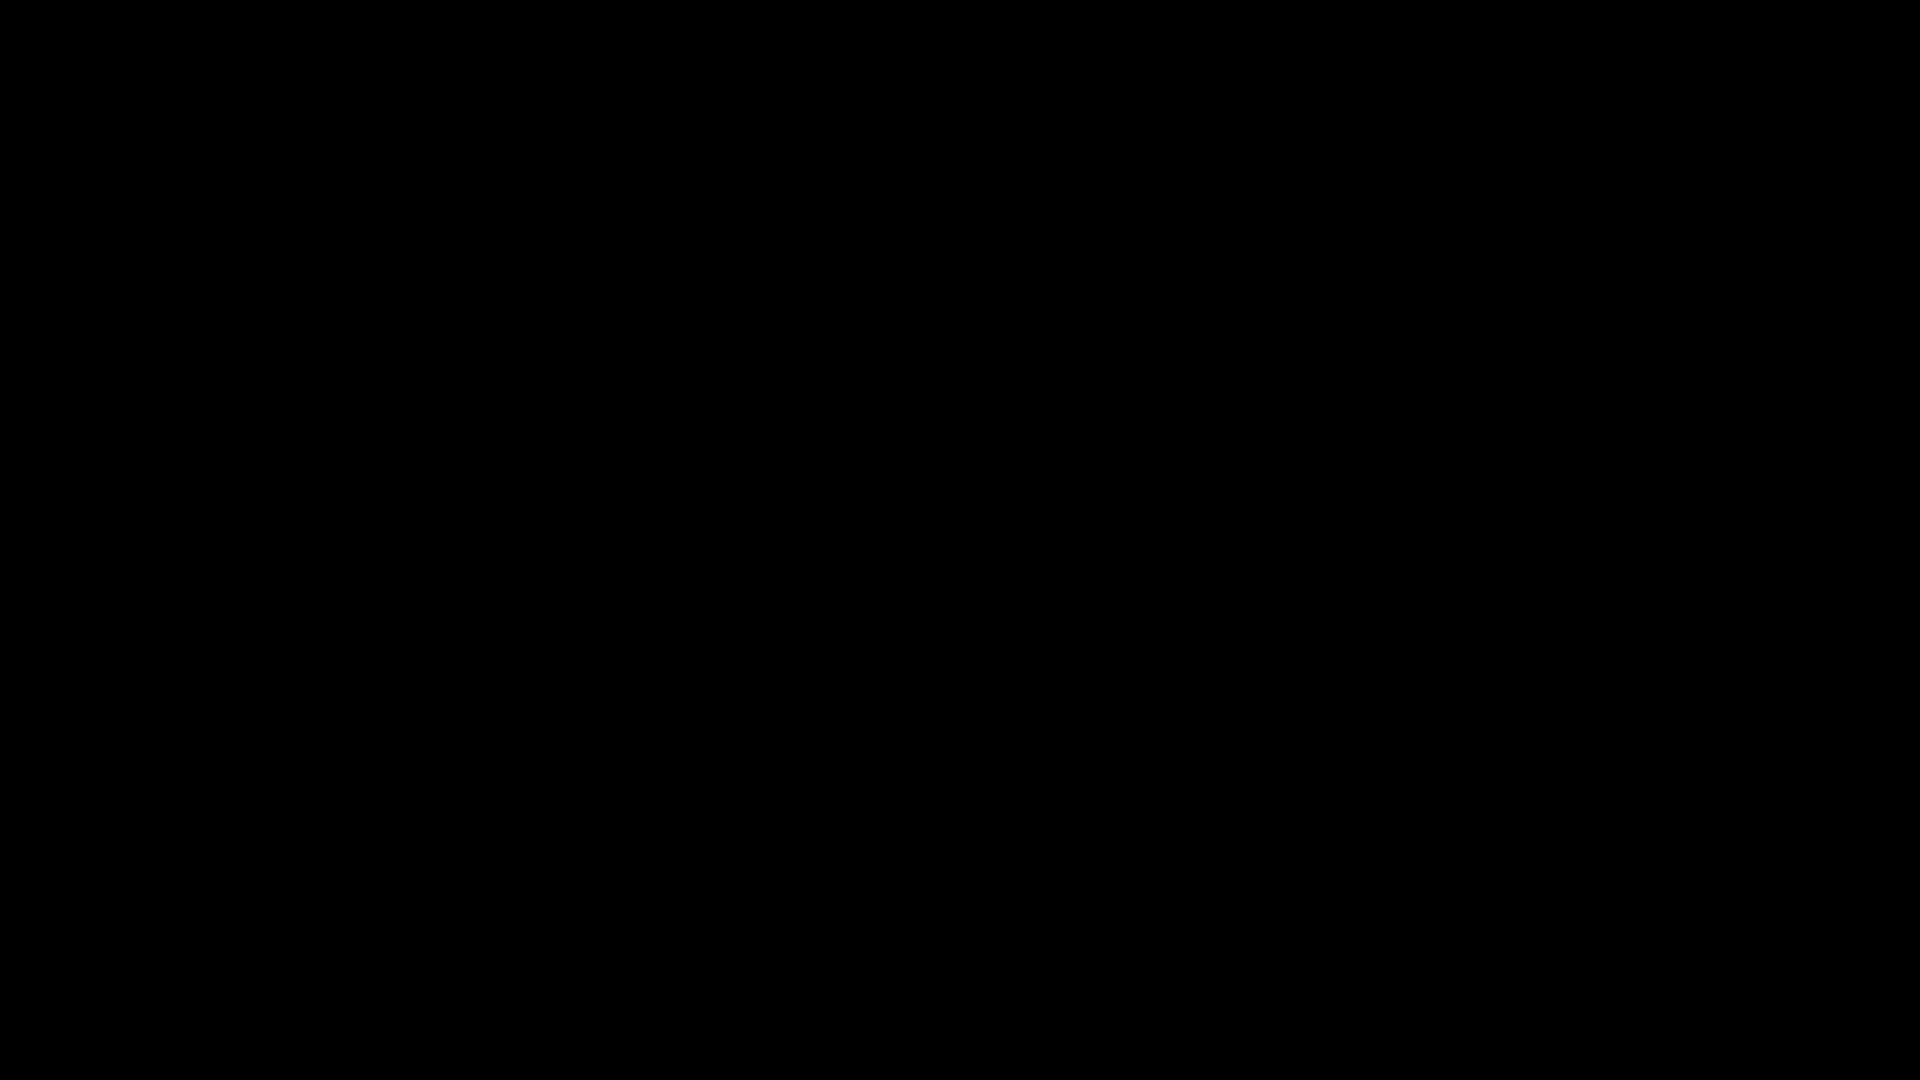

In [54]:
video_table.show()

In [55]:
video_table.add_column(transcription_text=video_table.transcription.text)

Computing cells: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 295.25 cells/s]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

In [57]:
sentence_view = pxt.create_view('transcription_demo.sentence_view',
                                video_table,
                                iterator=TextSplitter.create(text=video_table.transcription_text))

Inserting rows into `sentence_view`: 131 rows [00:00, 12487.87 rows/s]
Created view `sentence_view` with 131 rows, 0 exceptions.


In [58]:
sentence_view.select(sentence_view.pos, sentence_view.text).where(sentence_view.pos <= 10).show()

pos,text
0,The Snowflake back on track after a couple of months in the wilderness.
1,The last time we heard from this enterprise software data analytics companies back in February they put a strong quarter with a tepid four year forecast stock plunge from two hundred thirty down to the mid 100s.
2,Since then while many other tech names have rebounded like crazy stuff is only traded back up to 163 as of today's close.
3,But tonight these guys report tremendous core stuff like big expectations on every key line item for the quarter revenue product revenue operating income free cash flow.
4,You name it.
5,Take time as we gave a strong product revenue guidance for the current quarter and raise their full year product revenue forecast.
6,They gave you a little less a lower margin number but we'll find out about that.
7,So with the stock coming into the quarter cold these numbers were enough to send it higher.
8,And if you are just the beginning let's check in with Sridhar Ramaswamy.
9,He is the new CEO of Snowflake.


In [59]:
sentence_view.add_embedding_index(col_name='text', text_embed=e5_embed)

Computing cells: 100%|████████████████████████████████████████| 131/131 [00:01<00:00, 87.36 cells/s]


In [60]:
similarity = sentence_view.text.similarity('you should buy NVIDIA')
sentence_view.select(sentence_view.text, similarity).order_by(similarity, asc=False).limit(20).collect()

text,col_1
You still want to make sure that the applications working well or you want to try out a new model.,0.817813
Our foundation model Arctic was unsurprisingly done on top of Nvidia chips.,0.814672
Follow at Jim Cramer on X. Have a question.,0.812509
Let's talk about GPU because you've got your June 3rd to 6th data cloud summit.,0.812478
Head to mad money dot CNBC dot com.,0.810483
We are super excited by the promise of accelerated computing.,0.806162
You don't have to run GPUs if you want to use A.I. with Snowflake.,0.805502
Margins are really really important.,0.804435
I have to interrogate my own data.,0.804117
I don't know how much you need Amazon Web Services once you do that.,0.799093


In [61]:
video_table.insert([{'video': video_path} for video_path in paths[2:]])

Inserting rows into `video_table`: 1 rows [00:00, 182.07 rows/s]██| 4/4 [00:44<00:00, 11.25s/ cells]
Computing cells: 100%|████████████████████████████████████████████| 4/4 [00:45<00:00, 11.25s/ cells]
Inserting rows into `sentence_view`: 240 rows [00:00, 398.74 rows/s]
Inserted 241 rows with 0 errors.


UpdateStatus(num_rows=241, num_computed_values=4, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio,audio_meta
,,"{'size': 8266796, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 7290936576, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 516.648}], 'bit_rate': 128006, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"
,,"{'size': 10607276, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 9355239936, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 662.928}], 'bit_rate': 128005, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"

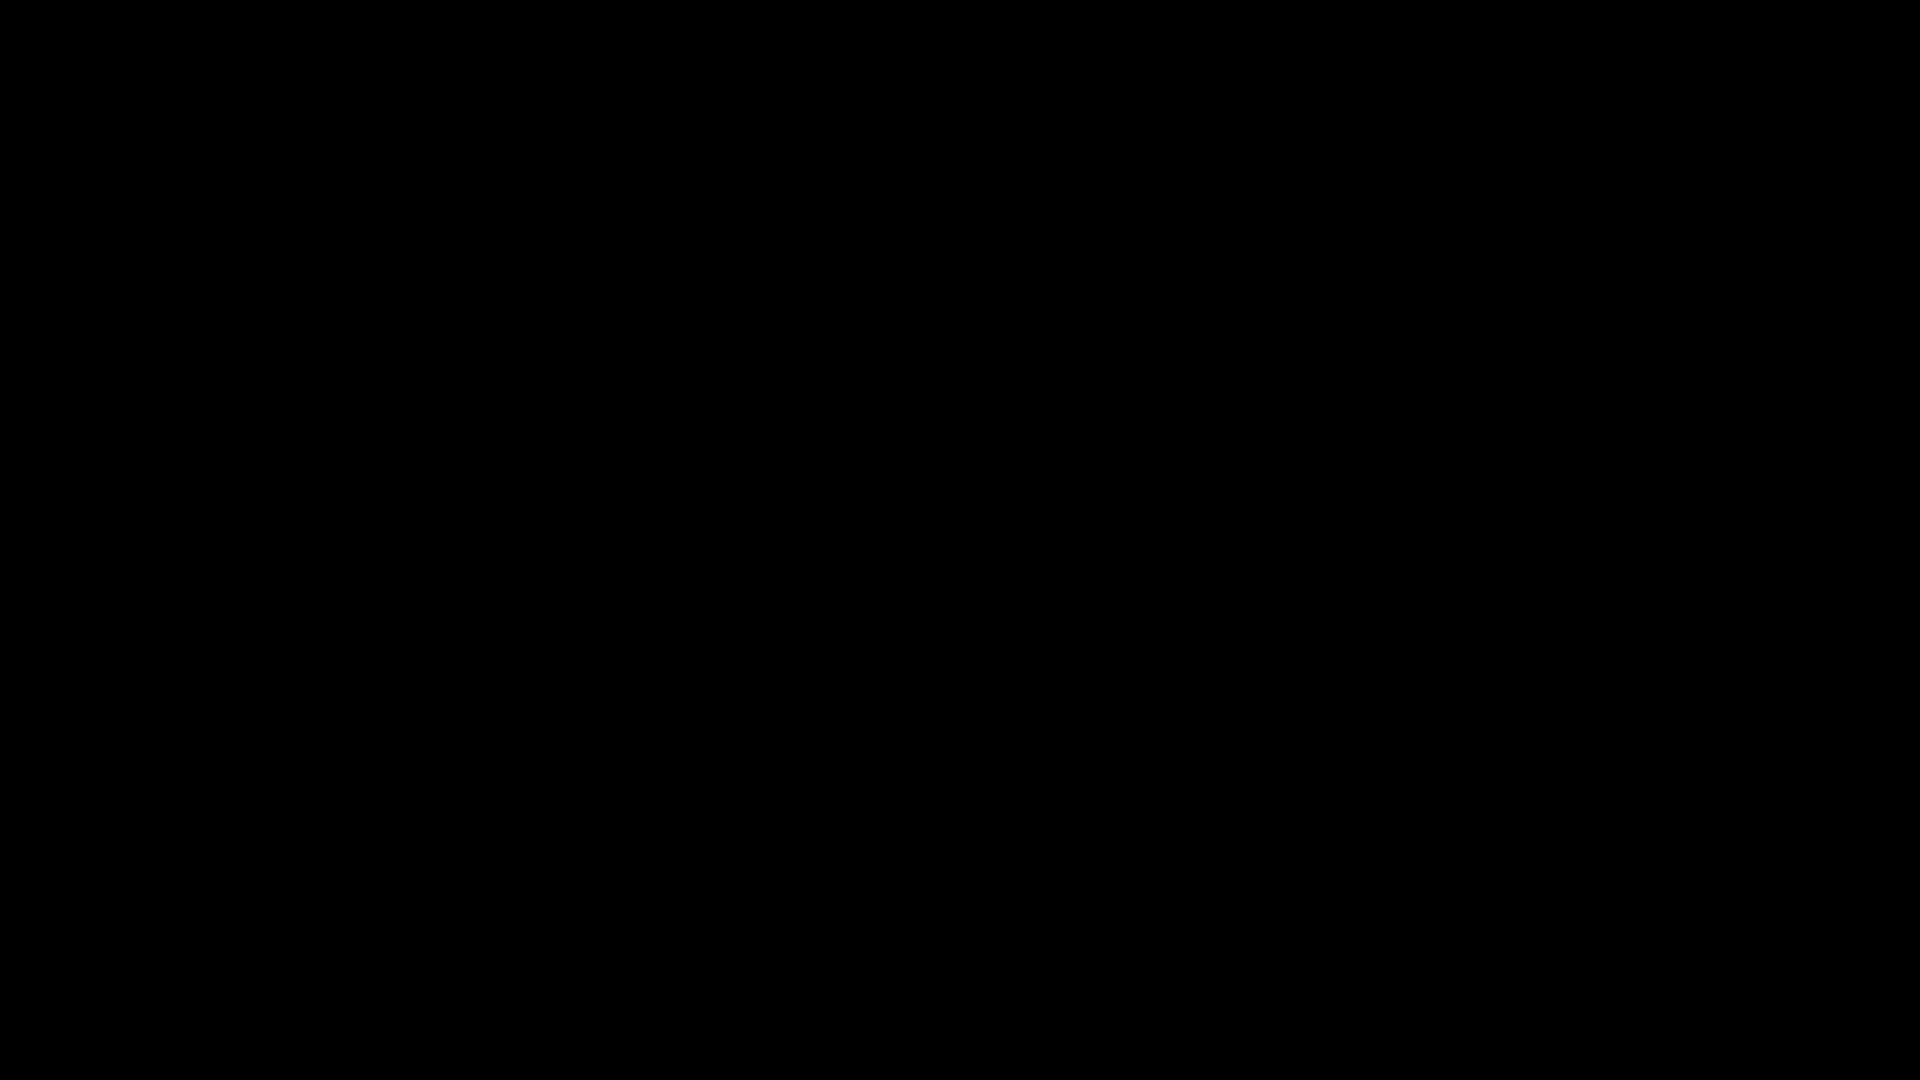
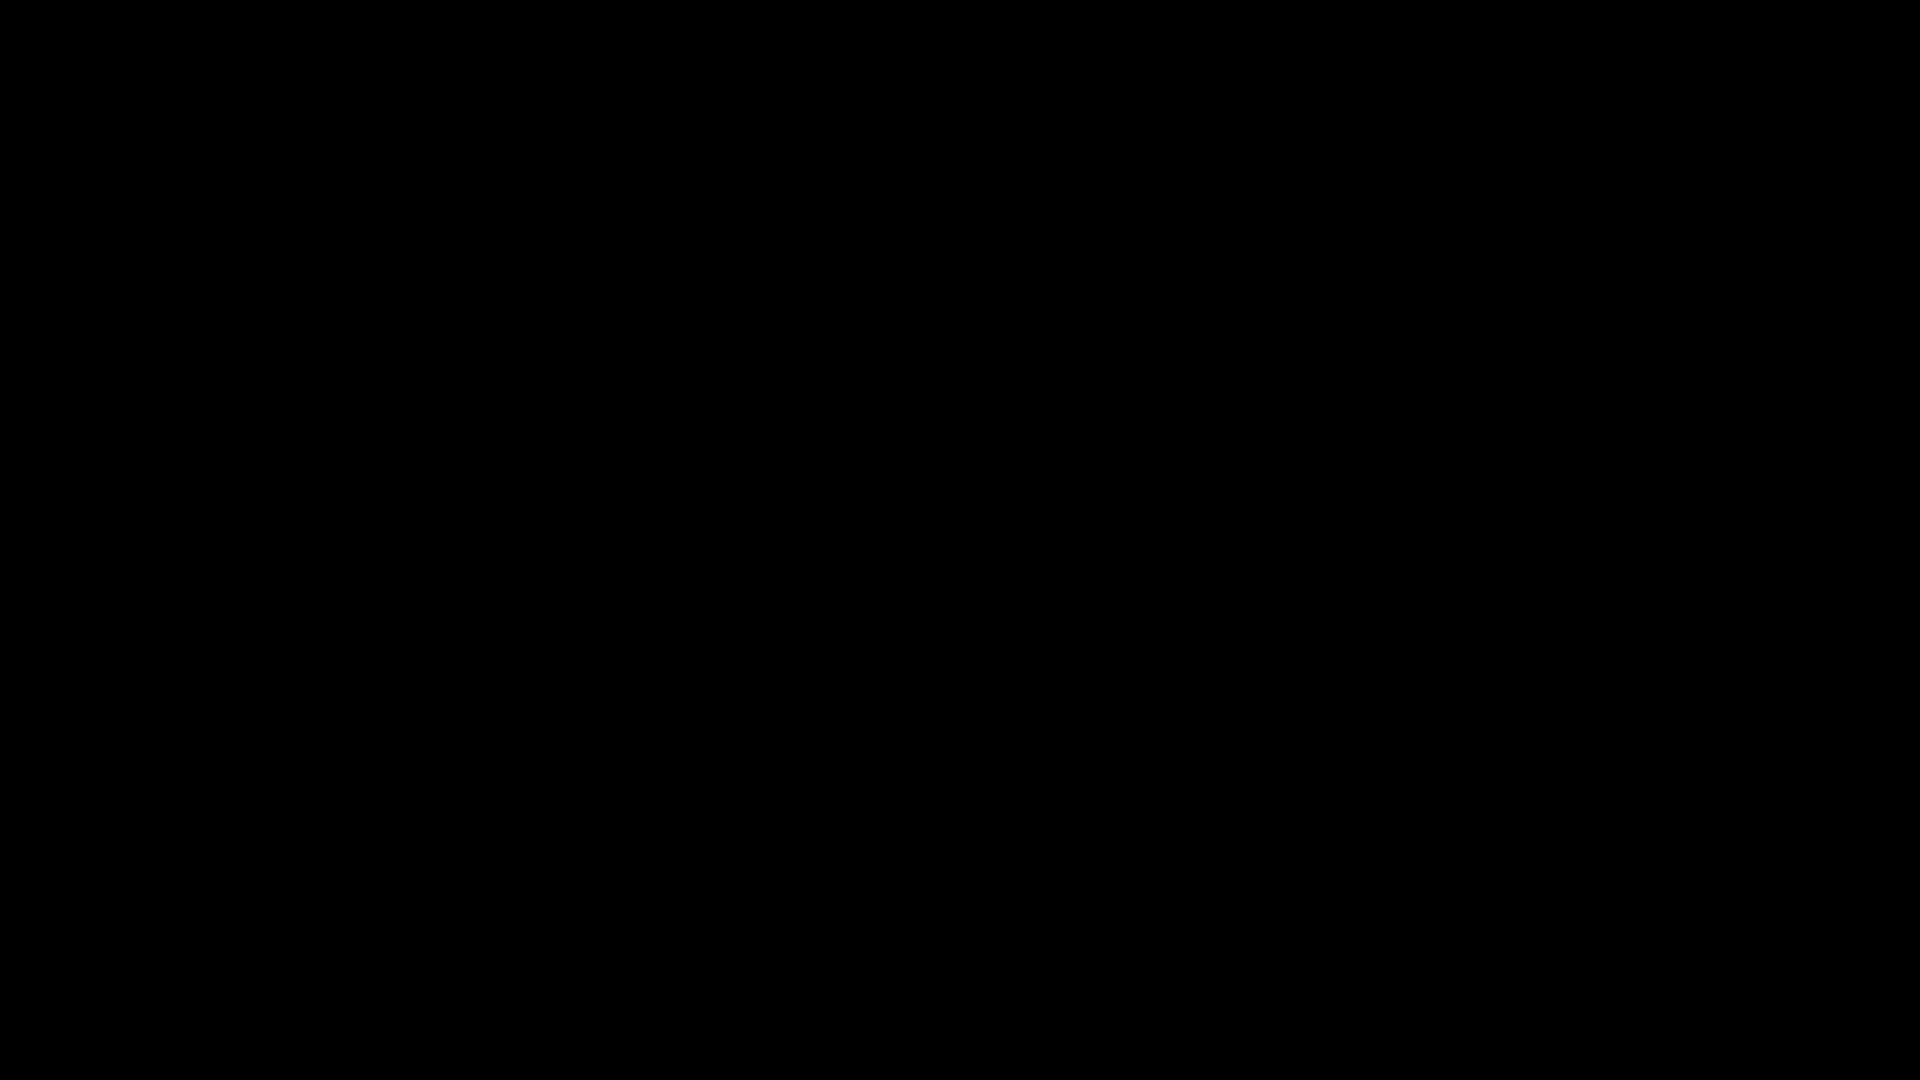

In [62]:
video_table.select(video_table.video, video_table.audio, video_table.audio_meta).show()